In [605]:
import pandas as pd
import random
import itertools
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import numpy as np
from fairlearn.datasets import fetch_acs_income
import shap
import os
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor


from scipy.spatial.distance import cosine, euclidean
from scipy.stats import mannwhitneyu, ks_2samp, shapiro, ttest_ind
from scipy.stats import uniform, randint
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score

import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBRegressor, XGBClassifier 


from scipy import stats
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind


In [208]:
data = fetch_acs_income()
# convert to df
raw_data = pd.DataFrame(data.data, columns=data.feature_names)
raw_data['target'] = data.target

# drop unknown feature
df = raw_data.drop(columns=['ST'], errors='ignore')

print(df.head())

   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P   target
0  18.0  1.0  18.0  5.0  4720.0  13.0  17.0  21.0  2.0    2.0   1600.0
1  53.0  5.0  17.0  5.0  3605.0  18.0  16.0  40.0  1.0    1.0  10000.0
2  41.0  1.0  16.0  5.0  7330.0   1.0  17.0  40.0  1.0    1.0  24000.0
3  18.0  6.0  18.0  5.0  2722.0   1.0  17.0   2.0  2.0    1.0    180.0
4  21.0  5.0  19.0  5.0  3870.0  12.0  17.0  50.0  1.0    1.0  29000.0


In [209]:
# check for missing values
df.isna().sum()

AGEP      0
COW       0
SCHL      0
MAR       0
OCCP      0
POBP      0
RELP      0
WKHP      0
SEX       0
RAC1P     0
target    0
dtype: int64

# Pre-processing

## Re-grouping data

In [210]:
df = df.copy()

# Categorize AGEP into bins
age_bins = [15, 25, 45, 60, float('inf')]
age_labels = ['18_25', '25_45', '45_60', '60_plus']
df['AGEP'] = pd.cut(df['AGEP'], bins=age_bins, labels=age_labels, right=False)

# Binarize MAR
df['MAR'] = df['MAR'].apply(lambda x: 1 if x == 1 else 0)

# Filter by RAC1P values
valid_rac1p_values = [1, 2, 6, 8, 9]
df = df[df['RAC1P'].isin(valid_rac1p_values)]


## Subsampling data

In [211]:
df['strata'] = df[['RAC1P','SEX', 'MAR', 'AGEP']].astype(str).agg('_'.join, axis=1)

# remove instances if they belong to a intersectional group with less than two occurences
df = df[df.groupby('strata')['strata'].transform('count') >= 2] 

sampled_data,_ = train_test_split(df, 
                             train_size=500_000, 
                             stratify=df['strata'], 
                             random_state=42)

sampled_data.drop('strata', axis=1, inplace=True)

In [212]:
len(sampled_data)

500000

Check for proportions

In [213]:
print(df['SEX'].value_counts(normalize=True))
print(sampled_data['SEX'].value_counts(normalize=True))

print(df['MAR'].value_counts(normalize=True))
print(sampled_data['MAR'].value_counts(normalize=True))


SEX
1.0    0.520814
2.0    0.479186
Name: proportion, dtype: float64
SEX
1.0    0.520816
2.0    0.479184
Name: proportion, dtype: float64
MAR
1    0.54716
0    0.45284
Name: proportion, dtype: float64
MAR
1    0.547154
0    0.452846
Name: proportion, dtype: float64


In [214]:
print(df['RAC1P'].value_counts(normalize=True))
print(sampled_data['RAC1P'].value_counts(normalize=True))

RAC1P
1.0    0.788277
2.0    0.089613
6.0    0.058538
8.0    0.038182
9.0    0.025392
Name: proportion, dtype: float64
RAC1P
1.0    0.788278
2.0    0.089614
6.0    0.058534
8.0    0.038180
9.0    0.025394
Name: proportion, dtype: float64


# Data visualisation

In [215]:
numeric_cols = ['WKHP']
categorical_cols = ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX',  'RAC1P'] 

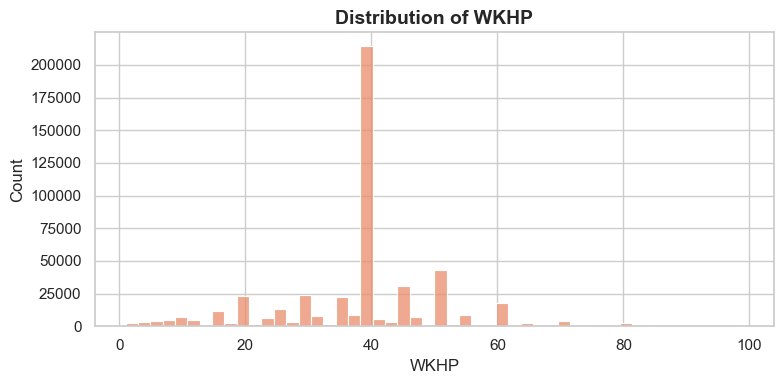

In [216]:
sns.set_theme(style="whitegrid", palette="flare")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(sampled_data[col], bins=50, kde=False, color=sns.color_palette("flare")[0])
    plt.title(f'Distribution of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

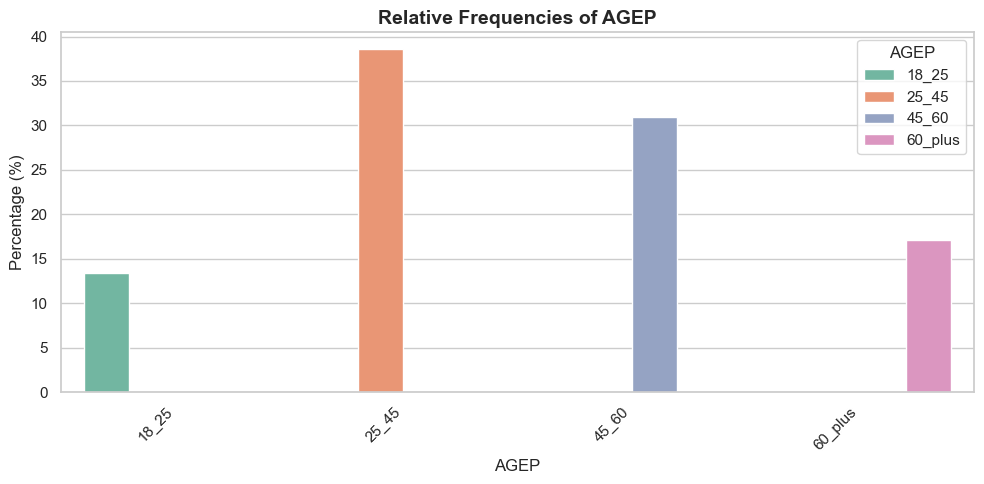

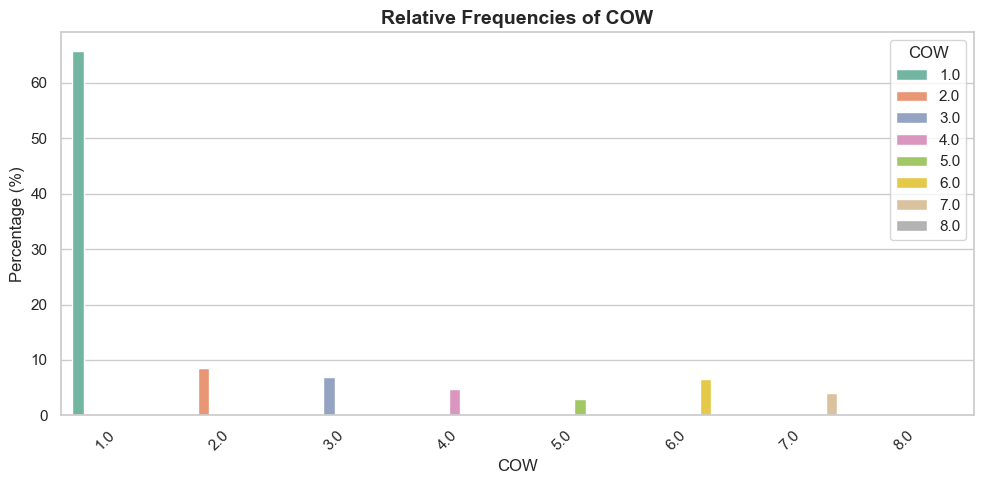

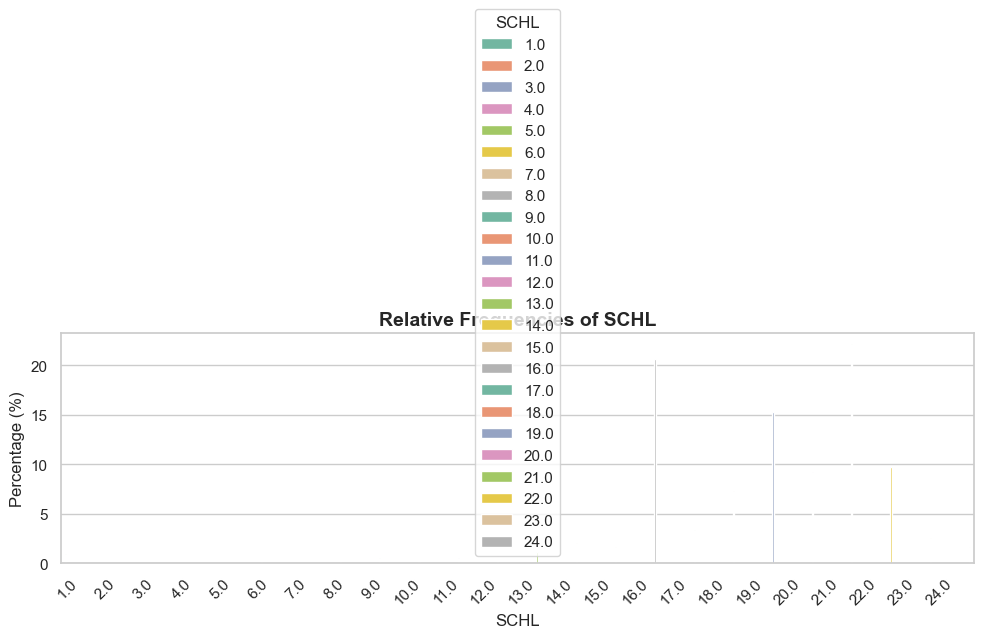

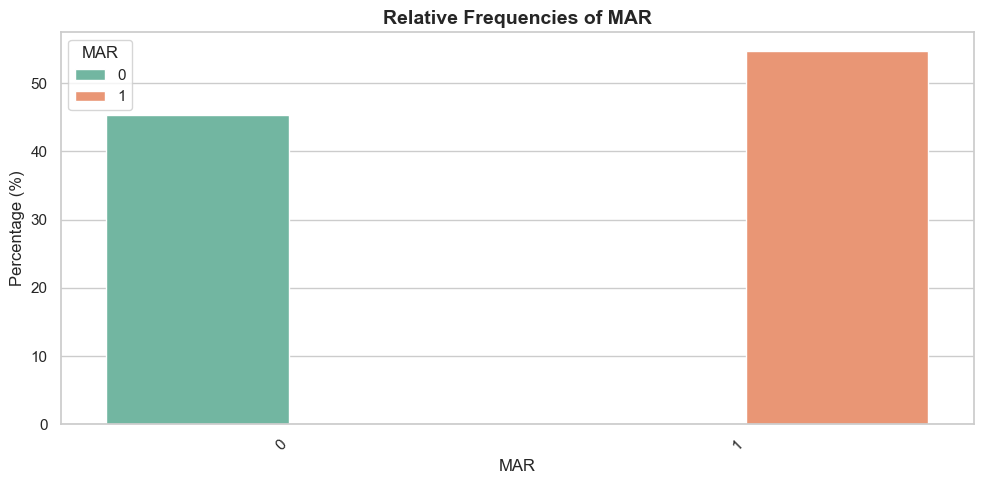

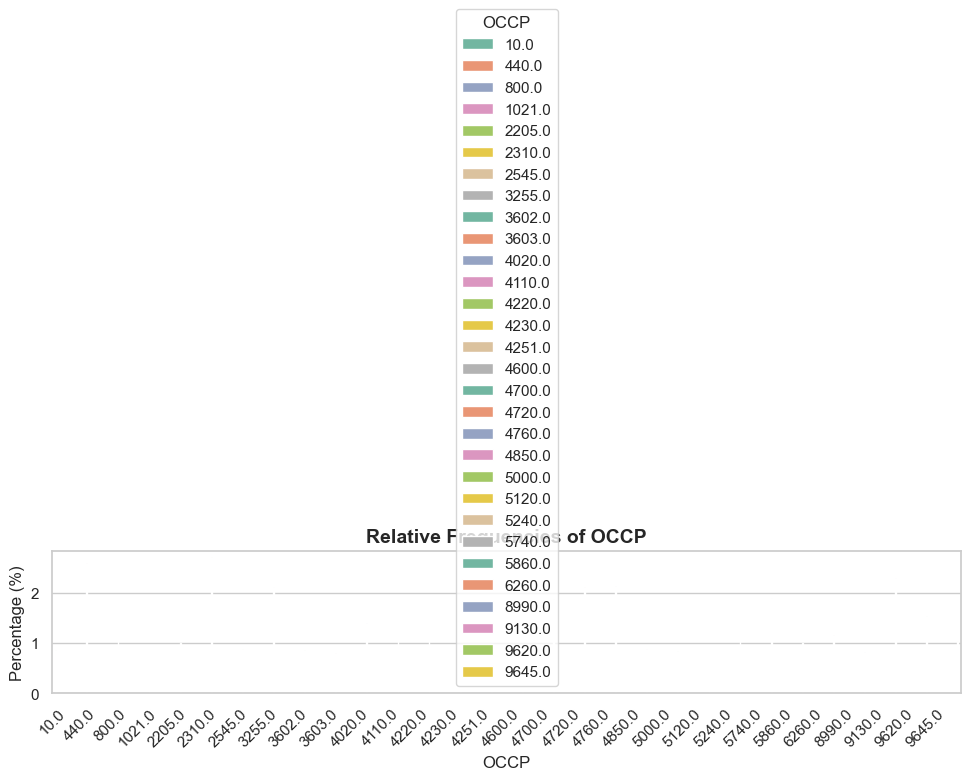

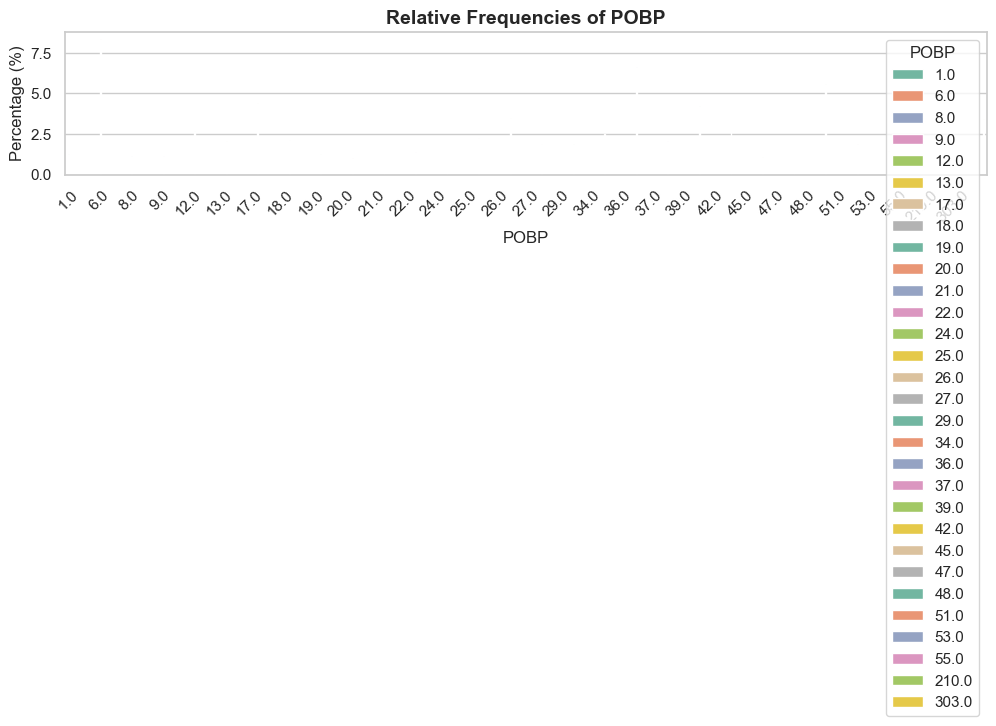

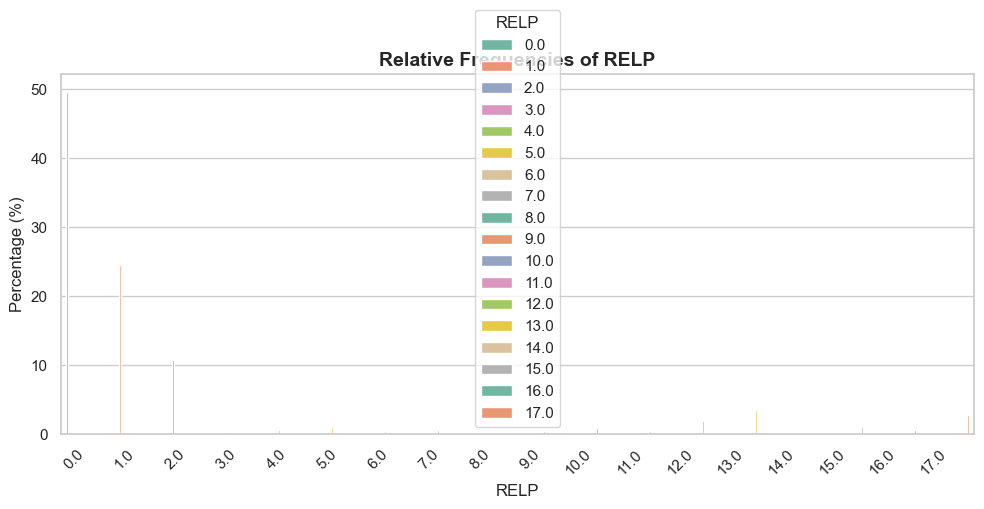

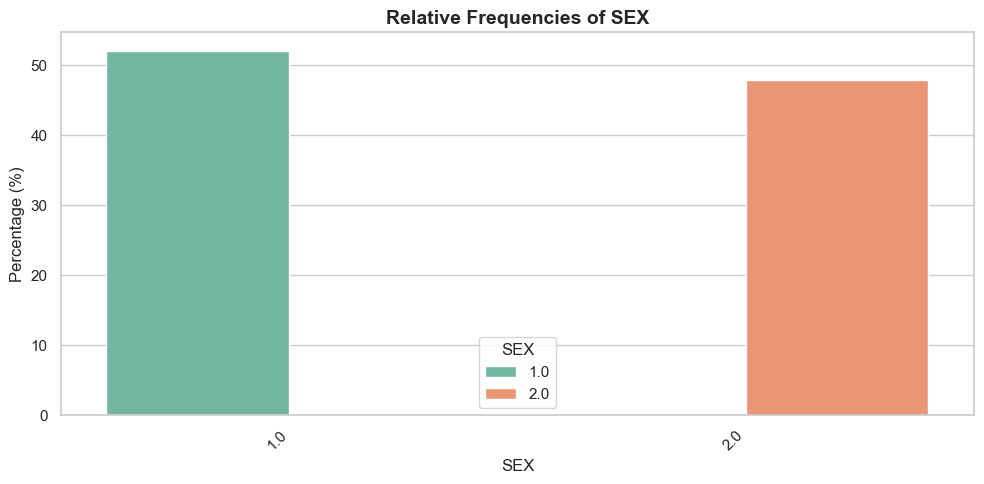

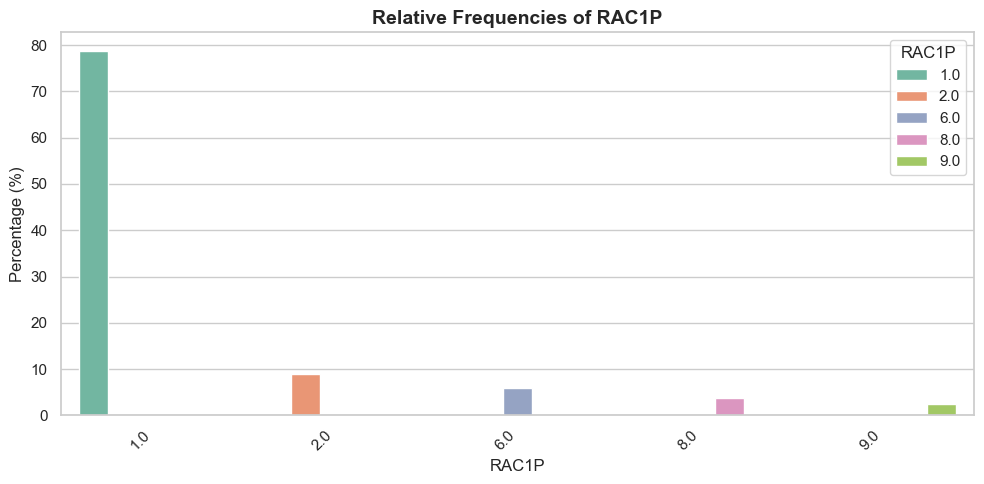

In [217]:
sns.set_theme(style="whitegrid", palette="Set2")

limit_top_n = 30
columns_to_limit = ['OCCP', 'POBP'] 


for col in categorical_cols:
    plt.figure(figsize=(10, 5))

    # value counts normalized
    value_counts = df[col].value_counts(normalize=True) * 100
    
    if col in columns_to_limit:
        value_counts = value_counts.head(limit_top_n)

    plot_df = value_counts.reset_index()
    plot_df.columns = [col, 'percentage']

    sns.barplot(data=plot_df, x=col, y='percentage', hue=col, palette="Set2")
    
    plt.title(f'Relative Frequencies of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Creating thresholds and splitting datasets

In [218]:
def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    return X, y


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols) 
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(sampled_data, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor.fit(X_train)

X_train_enc = preprocessor.transform(X_train)
X_val_enc   = preprocessor.transform(X_val)
X_test_enc  = preprocessor.transform(X_test)

In [219]:
y_train_arr = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_arr = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

In [220]:
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(feature_names) + numeric_cols

# **XGBoostClassifier** 

Hyperparamter grid search and training the best model

In [221]:
param_dist = {
    'n_estimators': randint(100, 700),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

n_iter = 20
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))
results = []

for i, params in enumerate(param_list):
    print(f"\n Running trial {i+1}/{n_iter}...")
    print("Params:", params)
    start = time.time()

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        **params
    )

    model.fit(X_train_enc, y_train)
    y_val_pred = model.predict(X_val_enc)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    duration = time.time() - start
    print(f"Finished trial {i+1}/{n_iter} — Val F1 (macro): {val_f1:.4f} — Time: {duration:.1f}s")

    results.append((params, val_f1))

# Get best model
best_params, best_score = max(results, key=lambda x: x[1])
print("\nBest Hyperparameters:", best_params)
print(f"Best Validation F1 (macro): {best_score:.4f}")

# Train best model on full training data
best_model = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **best_params
)
best_model.fit(X_train_enc, y_train)

# Final test evaluation
y_test_pred = best_model.predict(X_test_enc)



 Running trial 1/20...
Params: {'colsample_bytree': 0.6872700594236812, 'gamma': 4.75357153204958, 'learning_rate': 0.22959818254342154, 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': 0.15599452033620265, 'reg_lambda': 0.05808361216819946, 'subsample': 0.9330880728874675}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:19:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 1/20 — Val F1 (macro): 0.7994 — Time: 0.8s

 Running trial 2/20...
Params: {'colsample_bytree': 0.8005575058716043, 'gamma': 3.540362888980227, 'learning_rate': 0.016175348288740735, 'max_depth': 4, 'n_estimators': 443, 'reg_alpha': 0.8324426408004217, 'reg_lambda': 0.21233911067827616, 'subsample': 0.5909124836035503}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:19:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 2/20 — Val F1 (macro): 0.7709 — Time: 1.6s

 Running trial 3/20...
Params: {'colsample_bytree': 0.5917022549267169, 'gamma': 1.5212112147976886, 'learning_rate': 0.16742692948967136, 'max_depth': 14, 'n_estimators': 660, 'reg_alpha': 0.5247746602583891, 'reg_lambda': 0.3998609717152555, 'subsample': 0.5233328316068078}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:19:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 3/20 — Val F1 (macro): 0.8021 — Time: 3.9s

 Running trial 4/20...
Params: {'colsample_bytree': 0.9868777594207296, 'gamma': 1.1638567021515211, 'learning_rate': 0.03718193035984624, 'max_depth': 5, 'n_estimators': 666, 'reg_alpha': 0.9832308858067882, 'reg_lambda': 0.4667628932479799, 'subsample': 0.9299702033681603}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:19:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 4/20 — Val F1 (macro): 0.7902 — Time: 2.2s

 Running trial 5/20...
Params: {'colsample_bytree': 0.8401537692938899, 'gamma': 2.2524962598477147, 'learning_rate': 0.013979488347959958, 'max_depth': 11, 'n_estimators': 415, 'reg_alpha': 0.5632882178455393, 'reg_lambda': 0.3854165025399161, 'subsample': 0.5079831261101071}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:19:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 5/20 — Val F1 (macro): 0.7873 — Time: 3.4s

 Running trial 6/20...
Params: {'colsample_bytree': 0.6154469128110744, 'gamma': 1.2051273301300585, 'learning_rate': 0.21497905564763747, 'max_depth': 14, 'n_estimators': 608, 'reg_alpha': 0.8331949117361643, 'reg_lambda': 0.17336465350777208, 'subsample': 0.6955303037866204}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:19:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 6/20 — Val F1 (macro): 0.8002 — Time: 3.4s

 Running trial 7/20...
Params: {'colsample_bytree': 0.5911180438940311, 'gamma': 3.7768070515882624, 'learning_rate': 0.13754676234737342, 'max_depth': 8, 'n_estimators': 205, 'reg_alpha': 0.5677003278199915, 'reg_lambda': 0.03131329245555858, 'subsample': 0.9211423872974993}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:19:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 7/20 — Val F1 (macro): 0.7969 — Time: 0.9s

 Running trial 8/20...
Params: {'colsample_bytree': 0.7248770666848828, 'gamma': 1.9757511800090721, 'learning_rate': 0.28799765973813823, 'max_depth': 10, 'n_estimators': 561, 'reg_alpha': 0.1959828624191452, 'reg_lambda': 0.045227288910538066, 'subsample': 0.6626651653816322}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:19:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 8/20 — Val F1 (macro): 0.7996 — Time: 2.4s

 Running trial 9/20...
Params: {'colsample_bytree': 0.6943386448447411, 'gamma': 1.3567451588694794, 'learning_rate': 0.2586212527455788, 'max_depth': 12, 'n_estimators': 316, 'reg_alpha': 0.28093450968738076, 'reg_lambda': 0.5426960831582485, 'subsample': 0.5704621124873813}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 9/20 — Val F1 (macro): 0.8021 — Time: 1.7s

 Running trial 10/20...
Params: {'colsample_bytree': 0.9010984903770198, 'gamma': 0.3727532183988541, 'learning_rate': 0.3060660809801552, 'max_depth': 10, 'n_estimators': 228, 'reg_alpha': 0.1987156815341724, 'reg_lambda': 0.005522117123602399, 'subsample': 0.9077307142274171}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 10/20 — Val F1 (macro): 0.7996 — Time: 1.2s

 Running trial 11/20...
Params: {'colsample_bytree': 0.8534286719238086, 'gamma': 3.6450358402049368, 'learning_rate': 0.24138110400578372, 'max_depth': 7, 'n_estimators': 589, 'reg_alpha': 0.3584657285442726, 'reg_lambda': 0.11586905952512971, 'subsample': 0.9315517129377968}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 11/20 — Val F1 (macro): 0.8026 — Time: 1.6s

 Running trial 12/20...
Params: {'colsample_bytree': 0.811649063413779, 'gamma': 1.654490124263246, 'learning_rate': 0.02906750508580709, 'max_depth': 9, 'n_estimators': 673, 'reg_alpha': 0.32518332202674705, 'reg_lambda': 0.7296061783380641, 'subsample': 0.8187787356776066}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 12/20 — Val F1 (macro): 0.7963 — Time: 3.3s

 Running trial 13/20...
Params: {'colsample_bytree': 0.9436063712881633, 'gamma': 2.3610746258097466, 'learning_rate': 0.04587827378149051, 'max_depth': 5, 'n_estimators': 104, 'reg_alpha': 0.5612771975694962, 'reg_lambda': 0.770967179954561, 'subsample': 0.7468977981821954}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 13/20 — Val F1 (macro): 0.7700 — Time: 0.5s

 Running trial 14/20...
Params: {'colsample_bytree': 0.7613664146909971, 'gamma': 2.137705091792748, 'learning_rate': 0.017625738023228556, 'max_depth': 5, 'n_estimators': 674, 'reg_alpha': 0.8957635956735194, 'reg_lambda': 0.47537022318211175, 'subsample': 0.7816377859881918}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 14/20 — Val F1 (macro): 0.7815 — Time: 2.4s

 Running trial 15/20...
Params: {'colsample_bytree': 0.8477580432130638, 'gamma': 0.6966572720293784, 'learning_rate': 0.1913252137833452, 'max_depth': 13, 'n_estimators': 640, 'reg_alpha': 0.22879816549162246, 'reg_lambda': 0.07697990982879299, 'subsample': 0.6448757264568841}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 15/20 — Val F1 (macro): 0.7990 — Time: 3.8s

 Running trial 16/20...
Params: {'colsample_bytree': 0.5806106436270022, 'gamma': 4.648488261712865, 'learning_rate': 0.2524361138693251, 'max_depth': 11, 'n_estimators': 127, 'reg_alpha': 0.2184404372168336, 'reg_lambda': 0.4165099478703662, 'subsample': 0.9416401294594341}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 16/20 — Val F1 (macro): 0.8003 — Time: 0.7s

 Running trial 17/20...
Params: {'colsample_bytree': 0.662172510502637, 'gamma': 0.6104397735033668, 'learning_rate': 0.11688935142309247, 'max_depth': 3, 'n_estimators': 484, 'reg_alpha': 0.22793516254194168, 'reg_lambda': 0.4271077886262563, 'subsample': 0.9090073829612466}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 17/20 — Val F1 (macro): 0.7927 — Time: 1.1s

 Running trial 18/20...
Params: {'colsample_bytree': 0.9303652916281717, 'gamma': 0.03476065265595352, 'learning_rate': 0.16322419077326972, 'max_depth': 11, 'n_estimators': 417, 'reg_alpha': 0.22210781047073025, 'reg_lambda': 0.1198653673336828, 'subsample': 0.668807585701814}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 18/20 — Val F1 (macro): 0.8026 — Time: 2.3s

 Running trial 19/20...
Params: {'colsample_bytree': 0.9714548519562596, 'gamma': 1.6160146601037761, 'learning_rate': 0.16563718652300982, 'max_depth': 11, 'n_estimators': 212, 'reg_alpha': 0.06489224710898156, 'reg_lambda': 0.2539154139343447, 'subsample': 0.6234380314193007}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 19/20 — Val F1 (macro): 0.8008 — Time: 1.2s

 Running trial 20/20...
Params: {'colsample_bytree': 0.8481521364198942, 'gamma': 3.56135294962221, 'learning_rate': 0.05442607898601997, 'max_depth': 10, 'n_estimators': 180, 'reg_alpha': 0.266781014275285, 'reg_lambda': 0.9766149558326529, 'subsample': 0.7055185066591156}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:20:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 20/20 — Val F1 (macro): 0.7916 — Time: 1.2s

Best Hyperparameters: {'colsample_bytree': 0.8534286719238086, 'gamma': 3.6450358402049368, 'learning_rate': 0.24138110400578372, 'max_depth': 7, 'n_estimators': 589, 'reg_alpha': 0.3584657285442726, 'reg_lambda': 0.11586905952512971, 'subsample': 0.9315517129377968}
Best Validation F1 (macro): 0.8026


In [539]:
print("\n=== Test Performance: ===")
test_preds= best_model.predict(X_test_enc).ravel()
test_auc= roc_auc_score(y_test, test_preds)
print(f"Test AUC: {test_auc:.4f}")
print(classification_report(y_test, test_preds > 0.5))


=== Test Performance: ===
Test AUC: 0.8007
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     45340
           1       0.77      0.75      0.76     29660

    accuracy                           0.81     75000
   macro avg       0.80      0.80      0.80     75000
weighted avg       0.81      0.81      0.81     75000



In [540]:
best_model.save_model("best_xgboost_model.json")

# TreeSHAP

In [223]:
def rename_features(shap_values):
    custom_names = {
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1.0': 'Male',
    'SEX_2.0': 'Female',
    'RELP_0.0': 'Householder',
    'SCHL_21.0': 'Bachelors Degree',
    'SCHL_22.0': 'Masters Degree',
    'SCHL_23.0': 'Professional degree beyond a bachelos degree',
    'MAR_1.0': 'Married',
    'MAR_5.0': 'Never Married',
    'OCCP_3255.0': 'Occupation: Registered Nurse',
    'RELP_1.0': 'Husband/Wife of Householder',
    'RAC1P_2.0': 'Black or African American alone',
    'RAC1P_1.0': 'White alone'
    }
    renamed_features = [
        custom_names.get(name, name)
        for name in shap_values.feature_names
    ]
    return renamed_features

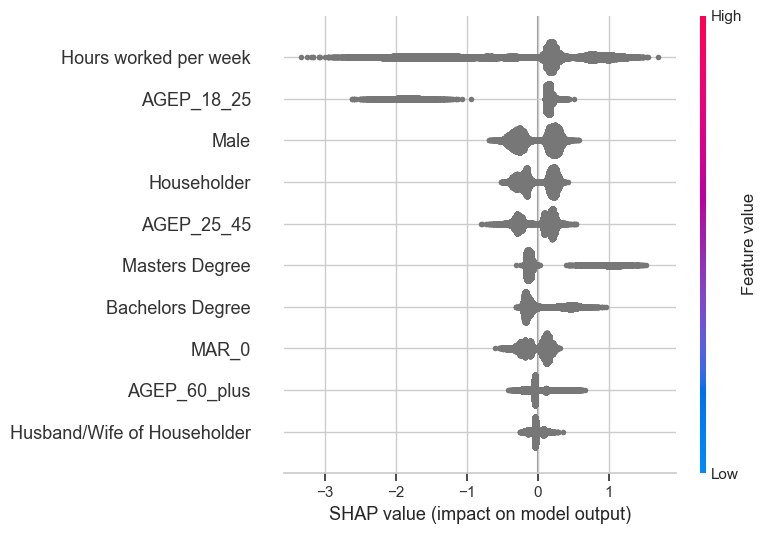

In [224]:
explainer = shap.Explainer(best_model, feature_names = all_feature_names)

tree_shap_values = explainer(X_test_enc)
tree_shap_values.feature_names = rename_features(tree_shap_values)
shap.summary_plot(tree_shap_values, X_test_enc, max_display=10)

In [225]:
# Save Tree SHAP-values
np.save("treeshap_values_fairlearn.npy", tree_shap_values.values)

# **Simple FFNN**

Hyperparamter grid search and training the best model

In [226]:
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))   # Input layer, preferred way
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

param_dist = {
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

def sample_params(param_dist):
    return {k: np.random.choice(v) for k, v in param_dist.items()}

n_iter = 10
input_dim = X_train_enc.shape[1]
results = []

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), cw))


for i in range(n_iter):
    params = sample_params(param_dist)
    print(f"Trial {i+1}/{n_iter} with params: {params}")

    model = build_ffnn(
        input_dim=input_dim,
        hidden_units=params['hidden_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

    model.fit(
        X_train_enc, y_train_arr,
        validation_data=(X_val_enc, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0, 
        class_weight=class_weights
        
    )

    val_preds = model.predict(X_val_enc).ravel()
    val_auc = roc_auc_score(y_val, val_preds)
    print(f"Val AUC: {val_auc:.4f}\n")

    results.append((params, val_auc))

# Find the best model
best_params, best_val_auc = max(results, key=lambda x: x[1])
print(f" Best Params: {best_params}\n Best Val AUC: {best_val_auc:.4f}")


# Build and train the best model
best_model_NN = build_ffnn(
    input_dim=input_dim,
    hidden_units=best_params['hidden_units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model_NN.fit(
    X_train_enc, y_train_arr,
    validation_data=(X_val_enc, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0,
    class_weight=class_weights)

Trial 1/10 with params: {'hidden_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 20}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step
Val AUC: 0.8930

Trial 2/10 with params: {'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 340us/step
Val AUC: 0.8906

Trial 3/10 with params: {'hidden_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 10}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step
Val AUC: 0.8882

Trial 4/10 with params: {'hidden_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step
Val AUC: 0.8918

Trial 5/10 with params: {'hidden_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 20}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step
Val AUC: 0.8895

Trial 6/10 with params: {'hidden_units': 128, 'dropout_rate': 0.4, 'learning_rat

In [227]:
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))   # Input layer, preferred way
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

n_iter = 10
input_dim = X_train_enc.shape[1]
results = []

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), cw))

best_params = {'hidden_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 20}

best_model_NN = build_ffnn(
    input_dim=input_dim,
    hidden_units=best_params['hidden_units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model_NN.fit(
    X_train_enc, y_train_arr,
    validation_data=(X_val_enc, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0,
    class_weight=class_weights)

In [541]:
print("\n=== Test Performance: ===")
test_preds= best_model_NN.predict(X_test_enc).ravel()
test_auc= roc_auc_score(y_test, test_preds)
print(f"Test AUC: {test_auc:.4f}")
print(classification_report(y_test, test_preds > 0.5))


=== Test Performance: ===
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step
Test AUC: 0.8946
              precision    recall  f1-score   support

           0       0.87      0.81      0.84     45340
           1       0.73      0.81      0.77     29660

    accuracy                           0.81     75000
   macro avg       0.80      0.81      0.80     75000
weighted avg       0.81      0.81      0.81     75000



In [542]:
best_model_NN.save("best_FFNN_model.keras")

# Deep SHAP

In [229]:
# sample representative background set and sample size
background_size = 5000 
test_sample_size = 10000

# stratified sample from training set
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss_train.split(X_train_enc, y_train))

# stratified sample from test set
X_test_array = X_test_enc.toarray() if hasattr(X_test_enc, "toarray") else X_test_enc
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_sample_size, random_state=42)
_, test_sample_idx = next(sss_test.split(X_test_array, y_test))
X_test_sample = X_test_array[test_sample_idx]

# set background 
background = X_train_enc[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background

# DeepSHAP values
explainer = shap.DeepExplainer(best_model_NN, background)
deep_shap_values = explainer.shap_values(X_test_sample).squeeze(-1)

/Users/linkamitome/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


In [230]:
# Save Deep SHAP values
np.save('deep_shap_values_fairlearn.npy', deep_shap_values)
np.save("test_sample_idx.npy", test_sample_idx) 


In [231]:
deep_shap_values.shape

(10000, 817)

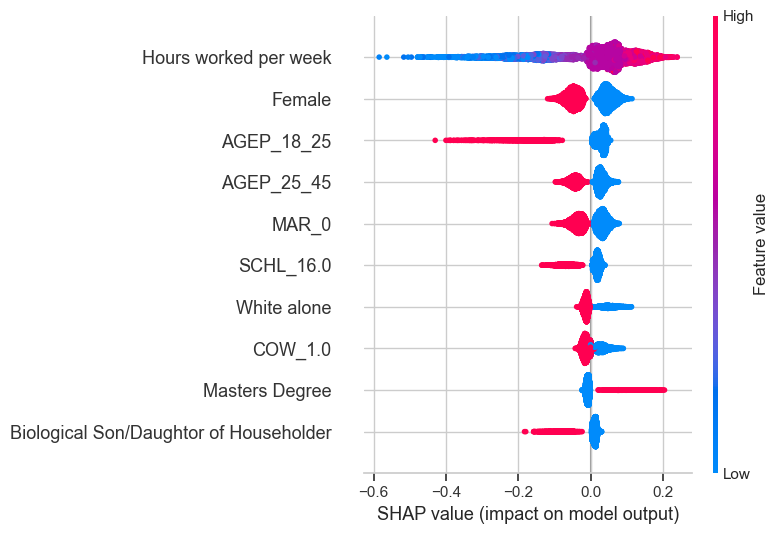

In [232]:
def rename_deep_shap_features(feature_name_list):
    custom_names = {
        'WKHP': 'Hours worked per week',
        'AGEP': 'Age',
        'SEX_1.0': 'Male',
        'SEX_2.0': 'Female',
        'RELP_0.0': 'Householder',
        'SCHL_21.0': 'Bachelors Degree',
        'SCHL_22.0': 'Masters Degree',
        'SCHL_23.0': 'Professional degree beyond a bachelors degree',
        'MAR_1.0': 'Married',
        'MAR_5.0': 'Never Married',
        'OCCP_3255.0': 'Occupation: Registered Nurse',
        'RELP_1.0': 'Husband/Wife of Householder',
        'RELP_2.0': 'Biological Son/Daughtor of Householder',
        'RAC1P_2.0': 'Black or African American alone',
        'RAC1P_1.0': 'White alone'
    }

    renamed_features = [custom_names.get(name, name) for name in feature_name_list]
    return renamed_features


renamed_feature_names = rename_deep_shap_features(all_feature_names)

shap.summary_plot(deep_shap_values, X_test_sample, feature_names=renamed_feature_names, max_display=10)

# Statistics

In [242]:
COW = {1:"Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
2:"Employee of a private not-for-profit, tax-exempt, or charitable organization",
3:"Local government employee (city, county, etc.)",
4:"State government employee",
5:"Federal government employee",
6:"Self-employed in own not incorporated business, professional practice, or farm",
7:"Self-employed in own incorporated business, professional practice or farm",
8:"Working without pay in family business or farm",
9:"Unemployed and last worked 5 years ago or earlier or never worked"}
SCHL = {1:"No schooling completed",
2:"Nursery school or preschool",
3:"Kindergarten",
4:"Grade 1",
5:"Grade 2",
6:"Grade 3",
7:"Grade 4",
8:"Grade 5",
9:"Grade 6",
10:"Grade 7",
11:"Grade 8",
12:"Grade 9",
13:"Grade 10",
14:"Grade 11",
15:"Grade 12 (no diploma)",
16:"Regular high school diploma",
17:"GED or alternative credential",
18:"Some college but less than 1 year",
19:"1 or more years of college credit but no degree",
20:"Associate’s degree",
21:"Bachelor’s degree",
22:"Master’s degree",
23:"Professional degree beyond a bachelor’s degree",
24:"Doctorate degree"}
MAR = {1:"Married", 2:"Widowed", 3:"Divorced",4:"Separated",5:"Never married or under 15 years old"}
RELP = {0:"Reference person",
1:"Husband or wife",
2:"Biological son or daughter",
3:"Adopted son or daughter",
4:"Stepson or stepdaughter",
5:"Brother or sister",
6:"Father or mother",
7:"Grandchild",
8:"Parent-in-law",
9:"Son-in-law or daughter-in-law",
10:"Other relative",
11:"Roomer or boarder",
12:"Housemate or roommate",
13:"Unmarried partner",
14:"Foster child",
15:"Other nonrelative",
16:"Institutionalized group quarters population. Includes correctional facilities, nursing homes, and mental hospitals.",
17:"Noninstitutionalized group quarters population. Includes college dormitories, military barracks, group homes, missions, and shelters."}
SEX = {1:"Male", 2:"Female"}
RAC1P = {1:"White alone",
2:"Black or African American alone",
3:"American Indian alone",
4:"Alaska Native alone",
5:"American Indian and Alaska native tribes specified; or American Indian or Alaska Native, not specified and no other races",
6:"Asian alone",
7:"Native Hawaiian and Other Pacific Islander alone",
8:"Some Other Race alone",
9:"Two or More races"}
AGEP = {
    '15_25': 'Age 15–25',
    '25_45': 'Age 25–45',
    '45_60': 'Age 45–60',
    '60_plus': 'Age 60+'
}

In [625]:
## Creating a dictionary for occupation codes and descriptions

mapping_df = pd.read_excel('2018-occupation-code-list-and-crosswalk.xlsx', sheet_name='2018 Census Occ Code List')
filtered_mapping = (mapping_df.iloc[9:].iloc[:, [1, 2]].dropna().reset_index(drop=True))
filtered_mapping = filtered_mapping[~filtered_mapping.iloc[:, 1].astype(str).str.contains("-")]
filtered_mapping.columns = ['Description', 'OCCP']
filtered_mapping.reset_index(drop=True, inplace=True)

OCCP = dict(zip(filtered_mapping['OCCP'].astype(int), filtered_mapping['Description']))

In [647]:
## Function to generate subgroups by taking all combinations of two features (e.g. sex and race)
def extract_subgroups(df, attr1, attr2):
    attr_values = {
        'SEX': [1, 2],
        'RAC1P': [1, 2, 6, 8, 9], # to-do: limit number of races
        'MAR': [0, 1],  # to-do: binarise
        'AGEP': ['18_25', '25_45', '45_60', '60_plus']
    }
    subgroups = {}

    for val1 in attr_values[attr1]:
        for val2 in attr_values[attr2]:
            subgroup_name = f"{attr1}_{val1}_{attr2}_{val2}"
            mask = (df[attr1] == val1) & (df[attr2] == val2)
            subgroups[subgroup_name] = mask.values 

    return subgroups

def cliffs_delta(x, y):
    """
    Efficient Cliff's Delta using NumPy broadcasting.
    Returns: delta (float), with sign
    """
    x = np.asarray(x)
    y = np.asarray(y)

    nx = len(x)
    ny = len(y)

    if nx == 0 or ny == 0:
        return np.nan

    # Compare all pairs
    diff = x[:, None] - y
    n_greater = np.sum(diff > 0)
    n_less = np.sum(diff < 0)

    delta = (n_greater - n_less) / (nx * ny)
    return delta

def robust_standardize(arr):
    med = np.median(arr)
    mad = np.median(np.abs(arr - med)) + 1e-9  # avoid zero division
    return (arr - med) / mad

def map_feature_name(feature):
    try:
        parts = feature.split('_')
        if parts[0] == 'AGEP':
            category_name = '_'.join(parts[1:])
            return AGEP.get(category_name, feature)
        else:
            target = parts[0]
            index = int(float(parts[1]))
            return (
                SCHL[index] if target == 'SCHL' else
                MAR[index] if target == 'MAR' else
                RELP[index] if target == 'RELP' else
                SEX[index] if target == 'SEX' else
                RAC1P[index] if target == 'RAC1P' else
                OCCP[index] if target == 'OCCP' else 
                feature
            )
    except:
        if feature == 'WKHP':
            return "working hours per week"
        return feature

In [648]:
def t_test_all_subgroups(df, filter_names, shap_values, attr1, attr2):
    subgroup_masks = extract_subgroups(df, attr1, attr2)
    shap_values_np = shap_values if isinstance(shap_values, np.ndarray) else shap_values.to_numpy()
    results = []
    removed_instances = 0

    subgroup_items = list(subgroup_masks.items())
    for (name1, mask1), (name2, mask2) in itertools.combinations(subgroup_items, 2):
        if mask1.sum() < 2 or mask2.sum() < 2:
            removed_instances +=1
            continue

        shap1 = shap_values_np[mask1]
        shap2 = shap_values_np[mask2]

        if shap1.shape[0] == 0 or shap2.shape[0] == 0:
            continue

        shap1_std = robust_standardize(shap1)
        shap2_std = robust_standardize(shap2)
        #compute them once for all features and store the results.
        ks_stats = [ks_2samp(shap1_std[:, i], shap2_std[:, i])[0] for i in range(shap1.shape[1])]

        def process_feature(i):
            if ks_stats[i] > 0.15:
                return None

            group1 = shap1[:, i]
            group2 = shap2[:, i]

            stat_u, p_mwu = mannwhitneyu(group1, group2, alternative='two-sided')
            if p_mwu >= 0.05:
                return None

            effect_size = cliffs_delta(group1, group2)
            if np.isnan(effect_size):
                return None

            return {
                'subgroup1': name1,
                'subgroup2': name2,
                'feature': filter_names[i],
                'feature description': map_feature_name(filter_names[i]),
                'KS D-test': ks_stats[i],
                'u-test statistic': stat_u,
                'mwu_p': p_mwu,
                'effect_size': effect_size,
                'mean_diff': group1.mean() - group2.mean()
            }

        with ThreadPoolExecutor(max_workers=2) as executor:
            future_results = executor.map(process_feature, range(shap1.shape[1]))
            results.extend(filter(None, future_results))
    
    print("Number of removed instances:", removed_instances)
    return pd.DataFrame(results)

## Tree SHAP 

In [609]:
# load tree shap values
treeshap_values = np.load("treeshap_values_fairlearn.npy")

In [610]:
occp_keys = [f"OCCP_{float(key)}" for key in OCCP.keys()]
schl_keys = [f"SCHL_{float(key)}" for key in SCHL.keys()]
all_filter_names = [*occp_keys, *schl_keys]
filter_names = [name for name in all_filter_names if name in all_feature_names]

# find index of features 
filter_indices = [i for i, feat in enumerate(all_feature_names) if feat in filter_names]
filtered_treeshap_values = treeshap_values[:, filter_indices]

In [657]:
attr_combinations = [
    ('RAC1P', 'SEX'),
    ('AGEP', 'SEX'),
    ('MAR', 'SEX'),
]

results_dict = {}  # key: 'health_mar_sex', value: DataFrame

for attr1, attr2 in attr_combinations:
    print(f"\n---- Analyzing Subgroups: {attr1} x {attr2} ----")

    try:
        df_result_treeshap = t_test_all_subgroups(X_test, filter_names, filtered_treeshap_values, attr1=attr1, attr2=attr2)
        df_result_treeshap['attr1'] = attr1
        df_result_treeshap['attr2'] = attr2
        result_key = f"{attr1.lower()}_{attr2.lower()}"
        results_dict[result_key] = df_result_treeshap

        significant_results = df_result_treeshap[(df_result_treeshap['mwu_p'] < 0.05) & ((df_result_treeshap['effect_size'] >= 0.33) | (df_result_treeshap['effect_size'] <= -0.33))]

        significant_results = significant_results.sort_values(by='effect_size', ascending=False)

        if significant_results.empty:
            print("No significant results")
        else:
            print(significant_results[['feature', 'feature description', 'subgroup1', 'subgroup2', 'effect_size', 'mwu_p']].head(20))

    except KeyError as e:
        print(f"Skipped due to missing column: {e}")
    except Exception as e:
        print(f"Error processing {attr1} x {attr2}: {e}")


---- Analyzing Subgroups: RAC1P x SEX ----
Number of removed instances: 0
          feature       feature description      subgroup1      subgroup2  \
275   OCCP_8335.0  Shoe and leather workers  RAC1P_1_SEX_1  RAC1P_2_SEX_1   
1074  OCCP_4030.0  Food preparation workers  RAC1P_2_SEX_2  RAC1P_8_SEX_1   

      effect_size          mwu_p  
275      0.400413  6.905791e-304  
1074    -0.366114   5.535315e-97  

---- Analyzing Subgroups: AGEP x SEX ----
Number of removed instances: 0
         feature                    feature description         subgroup1  \
582  OCCP_1440.0  Marine engineers and naval architects  AGEP_45_60_SEX_2   
538  OCCP_1440.0  Marine engineers and naval architects  AGEP_45_60_SEX_1   

              subgroup2  effect_size          mwu_p  
582  AGEP_60_plus_SEX_2    -0.343926  8.376891e-303  
538  AGEP_60_plus_SEX_1    -0.387937   0.000000e+00  

---- Analyzing Subgroups: MAR x SEX ----
Number of removed instances: 0
No significant results


In [658]:
import os
output_dir = "treeshap_stat_tests_nonparam"
os.makedirs(output_dir, exist_ok=True)

for name, df in results_dict.items():
    df.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)

## Deep SHAP comparisons

In [621]:
deepshap_values = np.load('deep_shap_values_fairlearn.npy')
test_sample_idx = np.load('test_sample_idx.npy')
X_test_sample_meta = X_test.iloc[test_sample_idx]

filtered_deepshap_values = deepshap_values[:, filter_indices]

In [656]:
attr_combinations = [
    ('RAC1P', 'SEX'),
    ('AGEP', 'SEX'),
    ('MAR', 'SEX'),
]

results_dict_deepshap = {}  # key: 'health_mar_sex', value: DataFrame

for attr1, attr2 in attr_combinations:
    print(f"\n---- Analyzing Subgroups: {attr1} x {attr2} ----")

    try:
        df_result_deepshap = t_test_all_subgroups(X_test_sample_meta, filter_names, filtered_deepshap_values, attr1=attr1, attr2=attr2)
        df_result_deepshap['attr1'] = attr1
        df_result_deepshap['attr2'] = attr2
        result_key = f"{attr1.lower()}_{attr2.lower()}"
        results_dict_deepshap[result_key] = df_result_deepshap

        significant_results = df_result_deepshap[(df_result_deepshap['mwu_p'] < 0.05) & ((df_result_deepshap['effect_size'] >= 0.33) | (df_result_deepshap['effect_size'] <= -0.33))]

        significant_results = significant_results.sort_values(by='effect_size', ascending=False)

        if significant_results.empty:
            print("No significant results")
        else:
            print(significant_results[['feature', 'feature description', 'subgroup1', 'subgroup2', 'effect_size', 'mwu_p']].head(20))

    except KeyError as e:
        print(f"Skipped due to missing column: {e}")
    except Exception as e:
        print(f"Error processing {attr1} x {attr2}: {e}")


---- Analyzing Subgroups: RAC1P x SEX ----
Number of removed instances: 0
          feature                                feature description  \
826   OCCP_6355.0                                       Electricians   
805   OCCP_2805.0        Broadcast announcers and radio disc jockeys   
561      SCHL_2.0                        Nursery school or preschool   
828   OCCP_7030.0                               Avionics technicians   
816   OCCP_4830.0                                      Travel agents   
834   OCCP_8365.0    Textile machine setters, operators, and tenders   
811   OCCP_4055.0                      Fast food and counter workers   
843   OCCP_9570.0    Conveyor, dredge, and hoist and winch operators   
1461  OCCP_3110.0                               Physician assistants   
3594   OCCP_120.0                                 Financial managers   
903   OCCP_6765.0     Miscellaneous construction and related workers   
1647     SCHL_2.0                        Nursery school or pr

In [659]:
output_dir = "deepshap_stat_tests_nonparam"
os.makedirs(output_dir, exist_ok=True)

for name, df in results_dict_deepshap.items():
    df.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)

# Fairness evaluation

## Conditional statistical parity

In [596]:
def conditional_statistical_parity(y_pred, legit_var, attr1, attr2):
    results = []
    legit_values = np.unique(legit_var)
    attr1_values = np.unique(attr1)
    attr2_values = np.unique(attr2)
    
    for l_val, (a1, a2) in itertools.product(legit_values, itertools.product(attr1_values, attr2_values)):
        mask = (legit_var == l_val) & (attr1 == a1) & (attr2 == a2)

        if np.sum(mask) == 0:
            continue # Skip empty subgroup

        results.append({
            'legitimate_value': l_val,
            'attr1_value': a1,
            'attr2_value': a2,
            'csp_rate': np.mean(y_pred[mask])
        })

    return pd.DataFrame(results)

In [597]:
def max_csp_difference(csp_results):
    max_row = csp_results.loc[csp_results["csp_rate"].idxmax()]
    min_row = csp_results.loc[csp_results["csp_rate"].idxmin()]

    return {
        "max_difference": max_row["csp_rate"] - min_row["csp_rate"],
        "max": {
            "legitimate_value": max_row["legitimate_value"],
            "attr1_value": max_row["attr1_value"],
            "attr2_value": max_row["attr2_value"],
            "csp_rate": max_row["csp_rate"],
        },
        "min": {
            "legitimate_value": min_row["legitimate_value"],
            "attr1_value": min_row["attr1_value"],
            "attr2_value": min_row["attr2_value"],
            "csp_rate": min_row["csp_rate"],
        },
    }

### XGBoost

In [598]:
xgboost_model = XGBClassifier()
xgboost_model.load_model("best_xgboost_model.json")
y_pred_xgboost = xgboost_model.predict(X_test_enc)

In [599]:
csp_results_dict = {}
legit_keys = ['SCHL', 'OCCP']
attr_combinations = [('RAC1P', 'SEX'), ('AGEP', 'SEX'), ('MAR', 'SEX')]

for attr1, attr2 in attr_combinations:
    for legit_key in legit_keys:
        result_key = f"{attr1.lower()}_{attr2.lower()}__{legit_key.lower()}"

        try:
            df_combined = pd.DataFrame({
                'y_pred': y_pred_xgboost,
                'legit_var': X_test[legit_key],
                'attr1': X_test[attr1],
                'attr2': X_test[attr2]
            })

            df_clean = df_combined.dropna()

            if df_clean.empty:
                print(f"{result_key} skipped: no non-NA rows.")
                continue

            y_pred = df_clean['y_pred'].values
            legit_var = df_clean['legit_var'].values
            attr1_vals = df_clean['attr1'].values
            attr2_vals = df_clean['attr2'].values

            csp_df = conditional_statistical_parity(y_pred, legit_var, attr1_vals, attr2_vals)
            csp_df = csp_df.dropna(subset=['csp_rate'])

            if csp_df.empty:
                print(f"{result_key} skipped: no valid CSP results.")
                continue

            csp_df_sorted = csp_df.sort_values(by='csp_rate')
            csp_results_dict[result_key] = csp_df_sorted

            csp_summary = max_csp_difference(csp_df_sorted)
            print(f"{result_key.upper()} CSP max difference: {csp_summary['max_difference']:.3f}")

        except KeyError as e:
            print(f"Skipped {result_key} due to missing column: {e}")
        except Exception as e:
            print(f"Error processing {result_key}: {e}")

In [600]:
os.makedirs("csp_results_xgboost", exist_ok=True)

for name, csp_df in csp_results_dict.items():
    csp_df.to_csv(f"csp_results_xgboost/{name}_csp.csv", index=False)

### FFNN

In [601]:
ffnn_model = keras.models.load_model("best_FFNN_model.keras")
y_pred_ffnn= best_model_NN.predict(X_test_enc).ravel()

In [602]:
csp_results_dict_ffnn = {}
legit_keys = ['SCHL', 'OCCP']
attr_combinations = [('RAC1P', 'SEX'), ('AGEP', 'SEX'), ('MAR', 'SEX')]

for attr1, attr2 in attr_combinations:
    for legit_key in legit_keys:
        result_key = f"{attr1.lower()}_{attr2.lower()}__{legit_key.lower()}"

        try:
            df_combined = pd.DataFrame({
                'y_pred': y_pred_ffnn,
                'legit_var': X_test[legit_key],
                'attr1': X_test[attr1],
                'attr2': X_test[attr2]
            })

            df_clean = df_combined.dropna()

            if df_clean.empty:
                print(f"{result_key} skipped: no non-NA rows.")
                continue

            y_pred = df_clean['y_pred'].values
            legit_var = df_clean['legit_var'].values
            attr1_vals = df_clean['attr1'].values
            attr2_vals = df_clean['attr2'].values

            csp_df = conditional_statistical_parity(y_pred, legit_var, attr1_vals, attr2_vals)
            csp_df = csp_df.dropna(subset=['csp_rate'])

            if csp_df.empty:
                print(f"{result_key} skipped: no valid CSP results.")
                continue

            csp_df_sorted = csp_df.sort_values(by='csp_rate')
            csp_results_dict_ffnn[result_key] = csp_df_sorted

            csp_summary = max_csp_difference(csp_df_sorted)
            print(f"{result_key.upper()} CSP max difference: {csp_summary['max_difference']:.3f}")

        except KeyError as e:
            print(f"Skipped {result_key} due to missing column: {e}")
        except Exception as e:
            print(f"Error processing {result_key}: {e}")

IndentationError: unexpected indent (828626140.py, line 43)

In [ ]:
os.makedirs("csp_results_ffnn", exist_ok=True)

for name, csp_df in csp_results_dict.items():
    csp_df.to_csv(f"csp_results_ffnn/{name}_csp.csv", index=False)

### Equalized odds (TPR & FPR)

In [ ]:
def equalized_odds(y_true, y_pred, protected_attr):
    groups = np.unique(protected_attr)
    tpr_diffs, fpr_diffs = [], []

    for g1, g2 in combinations(groups, 2):
        for label_val, label_name in [(1, "TPR"), (0, "FPR")]:
            idx1 = (y_true == label_val) & (protected_attr == g1)
            idx2 = (y_true == label_val) & (protected_attr == g2)


            if np.sum(idx1) == 0 or np.sum(idx2) == 0:
                continue

            rate1 = np.mean(y_pred[idx1])
            rate2 = np.mean(y_pred[idx2])
            diff = abs(rate1 - rate2)

            (tpr_diffs if label_val == 1 else fpr_diffs).append(diff)

    return {
        "TPR_diff": np.nanmean(tpr_diffs) if tpr_diffs else np.nan,
        "FPR_diff": np.nanmean(fpr_diffs) if fpr_diffs else np.nan
    }

### XGBoost

In [ ]:
attribute_pairs = [
    ("SEX", "MAR"),
    ("AGEP", "SEX"),
    ("RAC1P", "SEX"),
]

eo_results_xgboost = []

for attr1, attr2 in attribute_pairs:
    if attr1 not in X_test.columns or attr2 not in X_test.columns:
        print(f"  Skipping {attr1}+{attr2}")
        continue

    attr1_vals = X_test[attr1].values
    attr2_vals = X_test[attr2].values

    group_ids = np.array([f"{a1}_{a2}" for a1, a2 in zip(attr1_vals, attr2_vals)]) 

    eo_result = equalized_odds(y_test, y_pred_xgboost, group_ids)

    eo_results_xgboost.append({
        "attr1": attr1,
        "attr2": attr2,
        "TPR_diff": eo_result["TPR_diff"],
        "FPR_diff": eo_result["FPR_diff"]
    })

    print(f" Equalized Odds for {attr1}+{attr2} — TPR diff: {eo_result['TPR_diff']:.3f}, FPR diff: {eo_result['FPR_diff']:.3f}")

eo_df_xgboost = pd.DataFrame(eo_results_xgboost)
eo_df_xgboost.to_csv("equalized_odds_results_xgboost.csv", index=False)
print("\n Equalized Odds results saved to 'equalized_odds_results_xgboost.csv'")

 Equalized Odds for SEX+MAR — TPR diff: 0.130, FPR diff: 0.143
 Equalized Odds for AGEP+SEX — TPR diff: 0.288, FPR diff: 0.147
 Equalized Odds for RAC1P+SEX — TPR diff: 0.178, FPR diff: 0.076

 Equalized Odds results saved to 'equalized_odds_results_xgboost.csv'


### FFNN

In [ ]:
eo_results_ffnn = []

for attr1, attr2 in attribute_pairs:
    if attr1 not in X_test.columns or attr2 not in X_test.columns:
        print(f"  Skipping {attr1}+{attr2}")
        continue

    attr1_vals = X_test[attr1].values
    attr2_vals = X_test[attr2].values

    group_ids = np.array([f"{a1}_{a2}" for a1, a2 in zip(attr1_vals, attr2_vals)]) 

    eo_result = equalized_odds(y_test, y_pred_ffnn, group_ids)

    eo_results_ffnn.append({
        "attr1": attr1,
        "attr2": attr2,
        "TPR_diff": eo_result["TPR_diff"],
        "FPR_diff": eo_result["FPR_diff"]
    })

    print(f" Equalized Odds for {attr1}+{attr2} — TPR diff: {eo_result['TPR_diff']:.3f}, FPR diff: {eo_result['FPR_diff']:.3f}")

eo_df_ffnn = pd.DataFrame(eo_results_ffnn)
eo_df_ffnn.to_csv("equalized_odds_results_ffnn.csv", index=False)
print("\n Equalized Odds results saved to 'equalized_odds_results_ffnn.csv'")

 Equalized Odds for SEX+MAR — TPR diff: 0.089, FPR diff: 0.152
 Equalized Odds for AGEP+SEX — TPR diff: 0.208, FPR diff: 0.187
 Equalized Odds for RAC1P+SEX — TPR diff: 0.124, FPR diff: 0.073

 Equalized Odds results saved to 'equalized_odds_results_ffnn.csv'
